In [63]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
import scipy
import math
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Matplotlib Default Parameter

from matplotlib import rcParams
plt.style.use('fivethirtyeight')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# Alert Data

In [64]:
# Read alert data
a_df = pd.read_csv("/content/aggregate_alerts_Kota Sukabumi.csv")

# Drop duplicate rows
a_df_clean = a_df.drop_duplicates(keep='first')
a_df.sample(5)

,id,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,type,avg_location,total_records,date
487,6156062,2022-08-23 23:00:00.000,32.72,KOTA SUKABUMI,Pelabuhan 2,WEATHERHAZARD,"[106.88251099999987, -6.961726999999997]",60,2022-08-23
181,6129971,2022-08-17 16:00:00.000,32.72,KOTA SUKABUMI,N11 Lingkar Selatan Sukabumi,WEATHERHAZARD,"[106.918232, -6.949258999999997]",60,2022-08-17
298,6142912,2022-08-20 07:00:00.000,32.72,KOTA SUKABUMI,Cemerlang,WEATHERHAZARD,"[106.90545199999998, -6.92072100000001]",60,2022-08-20
450,6156025,2022-08-23 07:00:00.000,32.72,KOTA SUKABUMI,Cemerlang,WEATHERHAZARD,"[106.90545199999998, -6.92072100000001]",60,2022-08-23
442,6156017,2022-08-23 03:00:00.000,32.72,KOTA SUKABUMI,Cemerlang,WEATHERHAZARD,"[106.90545199999998, -6.92072100000001]",60,2022-08-23


In [65]:
# Check Number of Rows

print('Total Rows :', a_df.shape[0])
print('Total Features :', a_df.shape[1])

print('Total Rows :', a_df_clean.shape[0])
print('Total Features :', a_df_clean.shape[1])

Total Rows : 667
Total Features : 9
Total Rows : 667
Total Features : 9


No duplicate data, safe to use original dataset.

In [66]:
# EDA
list_item = []
for col in a_df.columns:
    list_item.append([col, a_df[col].dtype, a_df[col].isna().sum(), 100*a_df[col].isna().sum()/len(a_df[col]), a_df[col].nunique(), a_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,id,int64,0,0.000000,667,"[5930348, 5930349, 5930350, 5934828]"
1,time,object,0,0.000000,405,"[2022-07-06 13:00:00.000, 2022-07-06 17:00:00...."
2,kemendagri_kabupaten_kode,float64,0,0.000000,1,[32.72]
3,kemendagri_kabupaten_nama,object,0,0.000000,1,[KOTA SUKABUMI]
4,street,object,15,2.248876,35,"[N11 Pembangunan, RA Kosasih, Jenderal Ahmad Y..."
5,type,object,0,0.000000,3,"[JAM, WEATHERHAZARD, ACCIDENT]"
6,avg_location,object,0,0.000000,231,"[[106.95859599999996, -6.921270999999996], [10..."
7,total_records,int64,0,0.000000,63,"[30, 21, 10, 31]"
8,date,object,0,0.000000,51,"[2022-07-06, 2022-07-07, 2022-07-08, 2022-07-09]"


- Need to drop rows with null street value since we need it as key to join to other tables.
- id, kemendagri kabupaten kode, kemendagri kabupaten nama, average location, date can be dropped since it will not impact the analysis -> redundant.
- need to change time to datetime type.

In [67]:
# Drop unused columns
a_df = a_df[['time','street','type','total_records']]
# Drop null rows
a_df = a_df.dropna()
# Convert to datetime
a_df ['time'] = pd.to_datetime(a_df['time'])
a_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 666
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           652 non-null    datetime64[ns]
 1   street         652 non-null    object        
 2   type           652 non-null    object        
 3   total_records  652 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 25.5+ KB


In [68]:
# Descriptive statistics
a_df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_records,652.0,47.970859,20.482222,1.0,31.0,60.0,60.0,171.0


In [69]:
a_df.describe(exclude=[np.number]).T

,count,unique,top,freq,first,last
time,652,400,2022-08-18 12:00:00,10,2022-07-06 13:00:00,2022-09-04 18:00:00
street,652,35,Pelabuhan 2,178,NaT,NaT
type,652,3,WEATHERHAZARD,453,NaT,NaT


No irregular values detected.

# Jam Data

In [70]:
# Read jam data
j_df = pd.read_csv("/content/aggregate_median_jams_Kota Sukabumi.csv")

# Drop duplicate rows
j_df_clean = j_df.drop_duplicates(keep='first')
j_df.sample(5)

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry
56,2022-07-06 13:00:00.000,32.72,KOTA SUKABUMI,Surya Kencana,2,818.0,62.0,18.800,1,33470841,2022-07-06,2.0,"LINESTRING (106.927894 -6.919485, 106.928367 -..."
6411,2022-08-10 09:00:00.000,32.72,KOTA SUKABUMI,RA Kosasih,2,1429.0,64.0,27.290,7,35718042,2022-08-10,2.0,"MULTILINESTRING ((106.94276 -6.922359, 106.943..."
5617,2022-08-05 17:00:00.000,32.72,KOTA SUKABUMI,RE Martadinata,3,424.0,162.0,7.150,10,35392472,2022-08-05,3.0,"MULTILINESTRING ((106.927684 -6.919862, 106.92..."
2102,2022-07-16 18:00:00.000,32.72,KOTA SUKABUMI,RE Martadinata,2,910.0,92.0,17.030,13,34106412,2022-07-16,2.0,"MULTILINESTRING ((106.927684 -6.919862, 106.92..."
9863,2022-09-02 11:00:00.000,32.72,KOTA SUKABUMI,RA Kosasih,2,1638.0,113.5,23.695,10,37073945,2022-09-02,2.0,"MULTILINESTRING ((106.955319 -6.919399, 106.95..."


In [71]:
# Check Number of Rows

print('Total Rows :', j_df.shape[0])
print('Total Features :', j_df.shape[1])

print('Total Rows :', j_df_clean.shape[0])
print('Total Features :', j_df_clean.shape[1])

Total Rows : 10387
Total Features : 13
Total Rows : 10387
Total Features : 13


In [72]:
# EDA
list_item = []
for col in j_df.columns:
    list_item.append([col, j_df[col].dtype, j_df[col].isna().sum(), 100*j_df[col].isna().sum()/len(j_df[col]), j_df[col].nunique(), j_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,time,object,0,0.000000,1066,"[2022-07-06 04:00:00.000, 2022-07-06 06:00:00...."
1,kemendagri_kabupaten_kode,float64,0,0.000000,1,[32.72]
2,kemendagri_kabupaten_nama,object,0,0.000000,1,[KOTA SUKABUMI]
3,street,object,130,1.251564,111,"[Cikujang, N11 Lingkar Selatan Sukabumi, RA Ko..."
4,level,int64,0,0.000000,4,"[2, 1, 3, 4]"
5,median_length,float64,0,0.000000,1345,"[1040.0, 1736.0, 1554.0, 1661.0]"
6,median_delay,float64,0,0.000000,648,"[121.0, 72.5, 102.0, 92.0]"
7,median_speed_kmh,float64,0,0.000000,4096,"[19.15, 26.915, 23.82, 24.28]"
8,total_records,int64,0,0.000000,67,"[13, 8, 17, 1]"
9,id,int64,0,0.000000,10387,"[33470770, 33470771, 33470772, 33470773]"


- Need to drop rows with null street value since we need it as key to join to other tables.
- kemendagri kabupaten kode, kemendagri kabupaten nama, id, date, geometry can be dropped since it will not impact the analysis -> redundant.
- need to change time to datetime type and level to object.

In [73]:
# check if median level and level contain the different values
j_df[j_df['median_level']!= j_df['level']]

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry


Median level and level contain the same values, hence it also can be dropped.

In [74]:
# Drop unused columns
j_df = j_df[['time','street','level','median_length','median_delay','median_speed_kmh','total_records']]
# Drop null rows
j_df = j_df.dropna()
# Convert to datetime
j_df ['time'] = pd.to_datetime(j_df['time'])
# Convert to string
j_df['level'] = j_df ['level'].astype(str)
j_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10257 entries, 0 to 10386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              10257 non-null  datetime64[ns]
 1   street            10257 non-null  object        
 2   level             10257 non-null  object        
 3   median_length     10257 non-null  float64       
 4   median_delay      10257 non-null  float64       
 5   median_speed_kmh  10257 non-null  float64       
 6   total_records     10257 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 641.1+ KB


In [75]:
# Descriptive statistics
j_df.describe().T

,count,mean,std,min,25%,50%,75%,max
median_length,10257.0,964.888759,500.661923,152.00,622.00,882.00,1254.00,4199.00
median_delay,10257.0,118.490689,74.459396,59.50,74.50,95.00,133.50,1100.00
median_speed_kmh,10257.0,16.524415,6.343593,0.81,12.12,16.92,21.51,36.97
total_records,10257.0,9.310617,8.673205,1.00,3.00,8.00,12.00,83.00


In [76]:
# Descriptive statistics
j_df.describe(exclude=np.number).T

,count,unique,top,freq,first,last
time,10257,1063,2022-07-16 14:00:00,38,2022-07-06 04:00:00,2022-09-06
street,10257,111,RA Kosasih,1624,NaT,NaT
level,10257,4,2,4694,NaT,NaT


No irregular values detected

# Irregularities Data

In [77]:
# Read irregularities data
ir_df = pd.read_csv("/content/aggregate_median_irregularities_Kota Sukabumi.csv")

# Drop duplicate rows
ir_df_clean = ir_df.drop_duplicates(keep='first')
ir_df.sample(5)

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,jam_level,median_length,median_delay_seconds,median_regular_speed,total_records,cause_type,median_seconds,median_speed,date,median_jam_level,id,geometry
69,2022-08-16 15:00:00.000,32.72,KOTA SUKABUMI,KH Ahmad Sanusi,3,1698.5,560.5,26.265,8,NaN,715.5,8.80,2022-08-16,3.0,1558054,"MULTILINESTRING ((106.902032 -6.912024, 106.90..."
80,2022-09-01 17:00:00.000,32.72,KOTA SUKABUMI,RA Kosasih,2,2233.0,239.0,23.830,9,NaN,428.0,18.75,2022-09-01,2.0,1576817,"MULTILINESTRING ((106.955319 -6.919399, 106.95..."
12,2022-07-13 17:00:00.000,32.72,KOTA SUKABUMI,Jalan Selabintana,4,1661.0,877.0,22.210,1,NaN,1032.0,5.78,2022-07-13,4.0,1503749,"LINESTRING (106.935435 -6.910731, 106.935807 -..."
7,2022-07-08 18:00:00.000,32.72,KOTA SUKABUMI,Pelabuhan 2,3,2025.0,733.0,25.160,13,NaN,898.0,8.85,2022-07-08,3.0,1496728,"MULTILINESTRING ((106.895644 -6.958979, 106.89..."
38,2022-07-16 19:00:00.000,32.72,KOTA SUKABUMI,RA Kosasih,4,508.0,409.0,29.880,1,NaN,451.0,4.04,2022-07-16,4.0,1510870,"LINESTRING (106.950876 -6.920511, 106.95172 -6..."


In [78]:
# Check Number of Rows

print('Total Rows :', ir_df.shape[0])
print('Total Features :', ir_df.shape[1])

print('Total Rows :', ir_df_clean.shape[0])
print('Total Features :', ir_df_clean.shape[1])

Total Rows : 82
Total Features : 16
Total Rows : 82
Total Features : 16


In [79]:
# EDA
list_item = []
for col in ir_df.columns:
    list_item.append([col, ir_df[col].dtype, ir_df[col].isna().sum(), 100*ir_df[col].isna().sum()/len(ir_df[col]), ir_df[col].nunique(), ir_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,time,object,0,0.0,50,"[2022-07-06 17:00:00.000, 2022-07-07 13:00:00...."
1,kemendagri_kabupaten_kode,float64,0,0.0,1,[32.72]
2,kemendagri_kabupaten_nama,object,0,0.0,1,[KOTA SUKABUMI]
3,street,object,0,0.0,10,"[Jenderal Sudirman, Jenderal Ahmad Yani, RA Ko..."
4,jam_level,int64,0,0.0,3,"[4, 3, 2]"
5,median_length,float64,0,0.0,54,"[647.0, 792.0, 650.0, 2233.0]"
6,median_delay_seconds,float64,0,0.0,76,"[594.0, 156.0, 516.0, 663.5]"
7,median_regular_speed,float64,0,0.0,77,"[19.5, 20.44, 14.89, 21.32]"
8,total_records,int64,0,0.0,21,"[8, 7, 6, 10]"
9,cause_type,float64,82,100.0,0,[nan]


- kemendagri kabupaten kode, kemendagri kabupaten nama, cause type, date, id, meidan jam level, geometry can be dropped since it will not impact the analysis -> redundant.
- need to change time to datetime type and level to object.

In [80]:
# Drop unused columns
ir_df = ir_df[['time','street','jam_level','median_length','median_delay_seconds','median_seconds','median_regular_speed','total_records','median_speed']]
# Drop null rows
ir_df = ir_df.dropna()
# Convert to datetime
ir_df ['time'] = pd.to_datetime(ir_df['time'])
# Convert to string
ir_df['jam_level'] = ir_df ['jam_level'].astype(str)
ir_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  82 non-null     datetime64[ns]
 1   street                82 non-null     object        
 2   jam_level             82 non-null     object        
 3   median_length         82 non-null     float64       
 4   median_delay_seconds  82 non-null     float64       
 5   median_seconds        82 non-null     float64       
 6   median_regular_speed  82 non-null     float64       
 7   total_records         82 non-null     int64         
 8   median_speed          82 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 6.4+ KB


In [81]:
j_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10257 entries, 0 to 10386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              10257 non-null  datetime64[ns]
 1   street            10257 non-null  object        
 2   level             10257 non-null  object        
 3   median_length     10257 non-null  float64       
 4   median_delay      10257 non-null  float64       
 5   median_speed_kmh  10257 non-null  float64       
 6   total_records     10257 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 641.1+ KB


Irregularities and jam data set containing the same fields, except median seconds and median speed.

# Join the three datasets

In [87]:
j_ir_df = j_df.merge(ir_df, left_on=['street','time','level'], right_on =['street','time','jam_level'], how='left')
j_ir_df[j_ir_df['jam_level'].notnull()]

,time,street,level,median_length_x,median_delay,median_speed_kmh,total_records_x,jam_level,median_length_y,median_delay_seconds,median_seconds,median_regular_speed,total_records_y,median_speed
122,2022-07-06 17:00:00,Jenderal Sudirman,3,792.0,152.0,12.655,8,3,792.0,156.0,229.0,20.440000,7.0,12.440
124,2022-07-06 17:00:00,Jenderal Sudirman,4,647.0,594.0,3.570,8,4,647.0,594.0,656.5,19.500000,8.0,3.570
212,2022-07-07 13:00:00,Jenderal Ahmad Yani,4,718.5,501.5,5.465,26,4,650.0,516.0,590.0,14.890000,7.0,4.080
301,2022-07-07 17:00:00,RA Kosasih,3,2233.0,376.0,14.165,18,3,2233.0,663.5,863.0,21.320000,6.0,9.305
302,2022-07-07 17:00:00,RA Kosasih,4,1111.0,551.5,5.740,20,4,2233.0,688.5,887.5,21.224998,10.0,8.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7907,2022-08-20 13:00:00,KH Ahmad Sanusi,4,408.0,656.0,2.240,21,4,1535.0,701.0,871.0,25.430000,7.0,6.130
7925,2022-08-20 14:00:00,Jalan Raya Sukabumi,4,542.0,498.5,3.440,12,4,542.0,514.5,565.5,21.620000,8.0,3.445
9682,2022-09-01 17:00:00,RA Kosasih,4,521.0,237.0,6.860,14,4,1736.0,640.0,784.0,24.070000,4.0,7.910
9689,2022-09-01 17:00:00,RA Kosasih,2,2233.0,237.0,18.870,11,2,2233.0,239.0,428.0,23.830000,9.0,18.750


There are 82 overlapping columns between jam and irregularities dataset the numbers for median length and median delay differ but since the jam level is the same and jam dataset has much more data, it is decided to use jam dataset and discard the irregularities dataset.

In [92]:
# Determine if alert dataset has unique value for every time and street
count_df = a_df.groupby(['time','street'])['type'].aggregate([('count','count')])
count_df[count_df['count']>1]

,,count
time,street,
2022-07-13 17:00:00,Jalan Selabintana,2
2022-07-13 18:00:00,Jalan Selabintana,2
2022-07-24 15:00:00,Pesona Pangrango,3
2022-07-30 07:00:00,Parahita,2
2022-07-30 08:00:00,Parahita,2


Turns out that in one street and one time, there can be > 2 alert types. This means that there is no unique id to join to the jam dataset. Hence, we cannot use this dataset.

# Correlation Analysis

Objective: Decide to use jam dataset since it has the most features and rows. Goal is to PREDICT the level of jam.

In [93]:
j_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10257 entries, 0 to 10386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              10257 non-null  datetime64[ns]
 1   street            10257 non-null  object        
 2   level             10257 non-null  object        
 3   median_length     10257 non-null  float64       
 4   median_delay      10257 non-null  float64       
 5   median_speed_kmh  10257 non-null  float64       
 6   total_records     10257 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 641.1+ KB


In [97]:
# Encode target variable level to integer so the correlation can be calcualted.
j_df2 = j_df
j_df2['level'] = j_df2['level'].astype(int)

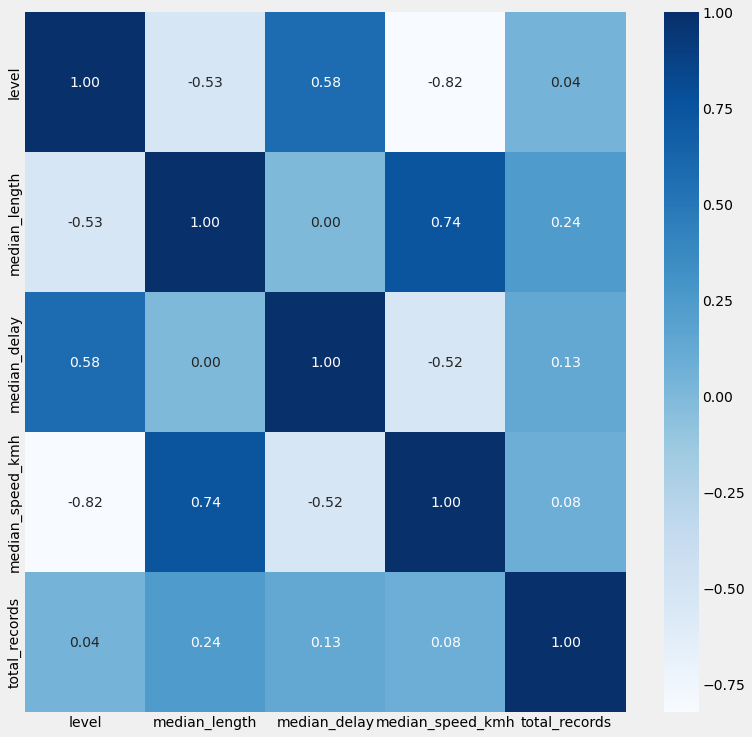

In [98]:
# Create Heatmap Correlation Chart for Each Numerical Features

plt.figure(figsize=(12, 12))
sns.heatmap(j_df2.corr(), cmap='Blues', annot=True, fmt='.2f')

- Correlation between total_records and level is <0.05 -> not significant, can be dropped
- Correlation between median_delay and level is moderately positive 0.58.
- Correlation between median_length and median_speed_kmh is 0.74, indicating multi colinearity, one of them should be dropped.
- Correlation between level and median speed kmh is -0.84, stronger than median length with -0.53 so median length should be dropped instead.

In [100]:
j_df3 = j_df2[['level','median_delay','median_speed_kmh']]
j_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10257 entries, 0 to 10386
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   level             10257 non-null  int64  
 1   median_delay      10257 non-null  float64
 2   median_speed_kmh  10257 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 320.5 KB


In [101]:
j_df3['level'].value_counts()

2    4694
3    2836
1    1974
4     753
Name: level, dtype: int64

In [106]:
j_df3.describe().T

,count,mean,std,min,25%,50%,75%,max
level,10257.0,2.230867,0.842242,1.00,2.00,2.00,3.00,4.00
median_delay,10257.0,118.490689,74.459396,59.50,74.50,95.00,133.50,1100.00
median_speed_kmh,10257.0,16.524415,6.343593,0.81,12.12,16.92,21.51,36.97


# Numerical Feature Scaling

In [102]:
# Import Robust Scaler Library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Splitting Data Train - Test
X_train, X_test, y_train, y_test = train_test_split(j_df3.drop('level', axis=1),
                                                    j_df3['level'],
                                                    test_size=0.3,
                                                    random_state=78)

print(f'Total Train Data = {X_train.shape[0]}')
print(f'Total Test Data = {X_test.shape[0]}')

Total Train Data = 7179
Total Test Data = 3078


In [103]:
# Declarate Scaler Function
# scaler = RobustScaler()
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fitting Scaler with Train Data
scaler.fit(X_train)

# Scaling Train and Test Data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
# Create DataFrame from Scaled Array Values

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [105]:
# Display Statistic Value of Numerical X Train Features After Scaling

X_test_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
median_delay,3078.0,0.057150,0.074603,0.000481,0.013936,0.033157,0.071120,0.952907
median_speed_kmh,3078.0,0.458128,0.189184,-0.005303,0.320271,0.469947,0.604817,1.060106


# Handling Imbalanced Target

In [107]:
y_train.value_counts()

2    3308
3    1967
1    1371
4     533
Name: level, dtype: int64

In [108]:
X_train_scaled.nunique()

median_delay         585
median_speed_kmh    3481
dtype: int64

In [109]:
from imblearn.over_sampling import SMOTE

# Random Over Sampling
sm = SMOTE(random_state=0)
sm.fit(X_train_scaled, y_train)
X_smote, y_smote = sm.fit_resample(X_train_scaled, y_train)

In [110]:
# Lets Check the Class Distribution
y_smote.value_counts()

2    3308
1    3308
4    3308
3    3308
Name: level, dtype: int64

In [112]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
median_delay,7179.0,0.056499,0.070221,0.0,0.014897,0.034118,0.070639,1.0
median_speed_kmh,7179.0,0.457520,0.185934,0.0,0.330510,0.469063,0.604302,1.0


In [113]:
X_smote.describe().T

,count,mean,std,min,25%,50%,75%,max
median_delay,13232.0,0.079903,0.099278,0.0,0.017299,0.044427,0.101259,1.0
median_speed_kmh,13232.0,0.399743,0.225756,0.0,0.171217,0.403138,0.597820,1.0


# Modeling

In [114]:
# Import Metrics Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score, make_scorer

# Import Models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

Since in this traffic case, false negative is more costly than false positve, we use recall to measure the score of the model.

In [135]:
# Define Algorithms

models = [LogisticRegression(random_state=42), KNeighborsClassifier(), GaussianNB(), SVC(random_state=42), DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42)]
for model in models:
  print(model)
  model.fit(X_smote,y_smote)
  y_pred = model.predict(X_test_scaled)
  y_train_pred = model.predict(X_smote)
  # print('precision_score Training',precision_score(y_smote, y_train_pred, average ='micro'))
  # print('precision_score Testing',precision_score(y_test, y_pred, average ='micro'))
  print('recall_score Training',recall_score(y_smote, y_train_pred, average ='micro'))
  print('recall_score Testing',recall_score(y_test, y_pred, average ='micro'))
  print('Difference',recall_score(y_smote, y_train_pred, average ='micro') - recall_score(y_test, y_pred, average ='micro'))
  # print('fbeta Training',fbeta_score(y_smote, y_train_pred, average ='micro',beta=2))
  # print('fbeta Testing',fbeta_score(y_test, y_pred, average ='micro',beta=2))
  print('\n')
  

LogisticRegression(random_state=42)
recall_score Training 0.7833282950423216
recall_score Testing 0.7095516569200779
Difference 0.07377663812224367


KNeighborsClassifier()
recall_score Training 0.8831620314389359
recall_score Testing 0.7248213125406108
Difference 0.15834071889832513


GaussianNB()
recall_score Training 0.7713119709794438
recall_score Testing 0.7069525666016894
Difference 0.06435940437775445


SVC(random_state=42)
recall_score Training 0.7922460701330108
recall_score Testing 0.7293697205977908
Difference 0.06287634953522003


DecisionTreeClassifier(random_state=42)
recall_score Training 0.9975816203143894
recall_score Testing 0.6920077972709552
Difference 0.30557382304343417


RandomForestClassifier(random_state=42)
recall_score Training 0.9975816203143894
recall_score Testing 0.742040285899935
Difference 0.25554133441445437


AdaBoostClassifier(random_state=42)
recall_score Training 0.664752116082225
recall_score Testing 0.4948018193632229
Difference 0.169950296719002

The baseline for a model to not be considered as overfitting is when train - test has absolute value of <= 0.1, hence the models which do not over fit are: logistic regression, gaussian, SVC, gradientboost and XGBclassifier.
The best recall score is GradientBoostingClassifier.